In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as helper
import random
import time

In [2]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [3]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.device(tf.config.list_physical_devices()[1])

2024-01-13 09:10:03.231857: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-13 09:10:03.231886: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-13 09:10:03.231900: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-13 09:10:03.232182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-13 09:10:03.232650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5


In [6]:
train_data_10_percent: tf.data.Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_data: tf.data.Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
class_names = train_data_10_percent.class_names

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
])

In [34]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [35]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 101)               155237    
                                                                 
Total params: 13085859 (49.92 MB)
Trainable params: 155237 (606.39 KB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

In [27]:
history_1 = model.fit(
    train_data_10_percent,
    epochs=EPOCHS,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[helper.create_checkpoint_callback("checkpoints", '06_model_1_101_classes_baseline')],
)

Saving model checkpoints to: checkpoints/06_model_1_101_classes_baseline/checkpoint.ckpt
Epoch 1/5
237/237 [==============================] - 73s 294ms/step - loss: 2.9303 - accuracy: 0.3566 - val_loss: 2.2517 - val_accuracy: 0.4605
Epoch 2/5
237/237 [==============================] - 66s 280ms/step - loss: 1.6847 - accuracy: 0.6049 - val_loss: 1.8808 - val_accuracy: 0.5328
Epoch 3/5
237/237 [==============================] - 66s 279ms/step - loss: 1.3061 - accuracy: 0.6933 - val_loss: 1.7441 - val_accuracy: 0.5522
Epoch 4/5
237/237 [==============================] - 66s 279ms/step - loss: 1.0671 - accuracy: 0.7538 - val_loss: 1.6785 - val_accuracy: 0.5636
Epoch 5/5
237/237 [==============================] - 66s 280ms/step - loss: 0.8945 - accuracy: 0.8012 - val_loss: 1.6594 - val_accuracy: 0.5678


In [28]:
evaluating_1 = model.evaluate(test_data)
evaluating_1

790/790 [==============================] - 147s 186ms/step - loss: 1.4463 - accuracy: 0.6182


[1.4463450908660889, 0.6181781888008118]

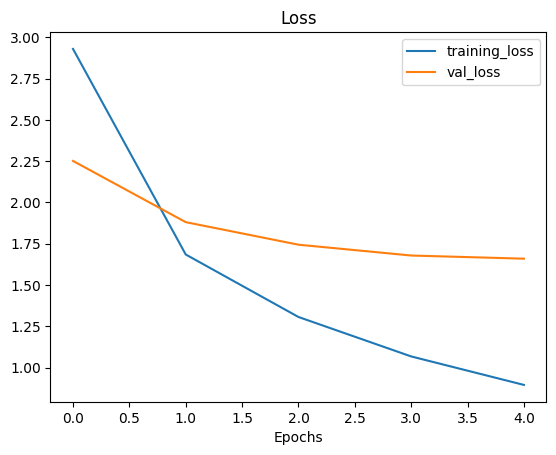

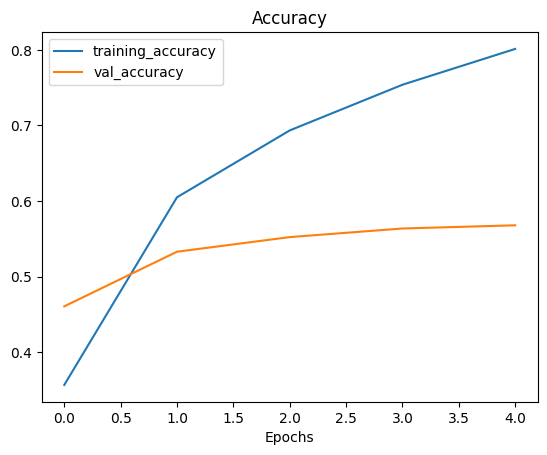

In [40]:
helper.plot_loss_curves(history_1)

In [19]:
base_model.trainable = True

for layers in base_model.layers[:-10]:
    layers.trainable = False
    
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    metrics=['accuracy'],
)

In [20]:
history_2 = model.fit(
    train_data_10_percent,
    epochs=EPOCHS + 5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_1.epoch[-1],
    # callbacks=[],
)

Epoch 5/10
237/237 [==============================] - 80s 313ms/step - loss: 0.6149 - accuracy: 0.8422 - val_loss: 1.5817 - val_accuracy: 0.5877
Epoch 6/10
237/237 [==============================] - 70s 295ms/step - loss: 0.4889 - accuracy: 0.8803 - val_loss: 1.6045 - val_accuracy: 0.5892
Epoch 7/10
237/237 [==============================] - 69s 291ms/step - loss: 0.3964 - accuracy: 0.9108 - val_loss: 1.6717 - val_accuracy: 0.5832
Epoch 8/10
237/237 [==============================] - 70s 296ms/step - loss: 0.3169 - accuracy: 0.9352 - val_loss: 1.7127 - val_accuracy: 0.5834
Epoch 9/10
237/237 [==============================] - 70s 294ms/step - loss: 0.2485 - accuracy: 0.9551 - val_loss: 1.7866 - val_accuracy: 0.5792
Epoch 10/10
237/237 [==============================] - 70s 294ms/step - loss: 0.1900 - accuracy: 0.9724 - val_loss: 1.8557 - val_accuracy: 0.5776


In [21]:
evaluating_2 = model.evaluate(test_data)
evaluating_2

790/790 [==============================] - 151s 191ms/step - loss: 1.6566 - accuracy: 0.6169


[1.6566184759140015, 0.6169108748435974]

In [22]:
evaluating_1

[1.4446511268615723, 0.6196039319038391]

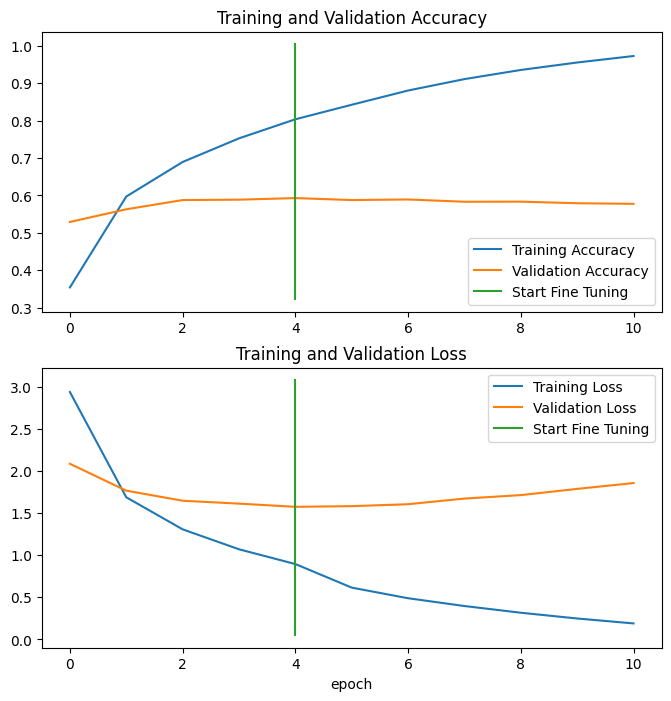

In [23]:
helper.compare_historys(history_1, history_2, EPOCHS)

In [37]:
model.load_weights("checkpoints/06_model_1_101_classes_baseline")
# model.load_weights("06_transfer_learning_101_classes/checkpoint.ckpt")

In [30]:
model.save('models/06_base_model')

INFO:tensorflow:Assets written to: models/06_base_model/assets


INFO:tensorflow:Assets written to: models/06_base_model/assets


In [13]:
loaded_model = tf.keras.models.load_model('models/06_base_model')

In [32]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 156s 193ms/step - loss: 1.4447 - accuracy: 0.6196


[1.4446511268615723, 0.6196039319038391]

In [33]:
evaluating_1

[1.4446511268615723, 0.6196039319038391]

In [29]:
base_model.trainable = True

for layers in base_model.layers[:-10]:
    layers.trainable = False
    
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics=['accuracy'],
)

history_3 = model.fit(
    train_data_10_percent,
    epochs=EPOCHS + 5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_1.epoch[-1],
    # callbacks=[],
)

evaluating_3 = model.evaluate(test_data)
evaluating_3

Epoch 5/10


237/237 [==============================] - 80s 312ms/step - loss: 0.7416 - accuracy: 0.7980 - val_loss: 1.7348 - val_accuracy: 0.5530
Epoch 6/10
237/237 [==============================] - 70s 294ms/step - loss: 0.3934 - accuracy: 0.9038 - val_loss: 1.8422 - val_accuracy: 0.5553
Epoch 7/10
237/237 [==============================] - 68s 287ms/step - loss: 0.1849 - accuracy: 0.9659 - val_loss: 1.8610 - val_accuracy: 0.5779
Epoch 8/10
237/237 [==============================] - 69s 289ms/step - loss: 0.0747 - accuracy: 0.9925 - val_loss: 2.1684 - val_accuracy: 0.5572
Epoch 9/10
237/237 [==============================] - 69s 289ms/step - loss: 0.0356 - accuracy: 0.9971 - val_loss: 2.2946 - val_accuracy: 0.5593
Epoch 10/10
790/790 [==============================] - 150s 189ms/step - loss: 2.0520 - accuracy: 0.6109


[2.0519518852233887, 0.6109306812286377]

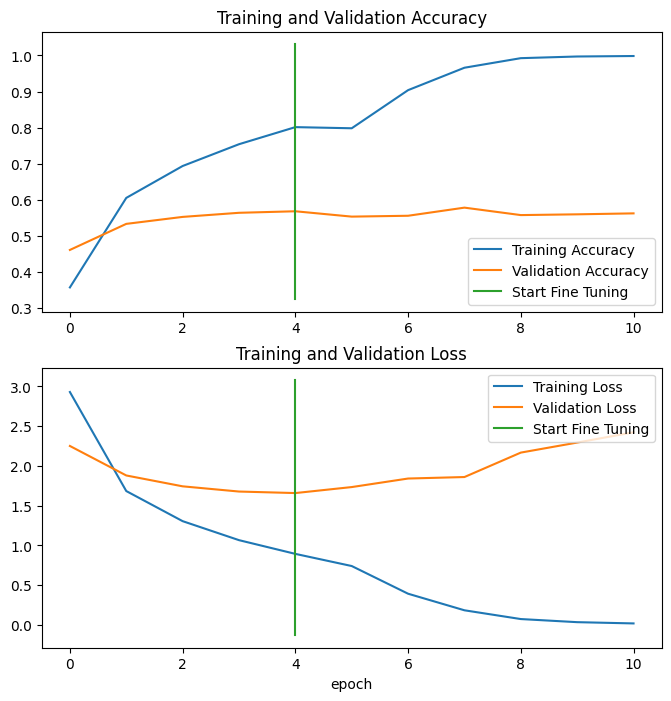

In [30]:
helper.compare_historys(history_1, history_3, EPOCHS)

In [37]:
model.load_weights("checkpoints/06_model_1_101_classes_baseline/checkpoint.ckpt")


In [38]:


base_model.trainable = True

for layers in base_model.layers[:-20]:
    layers.trainable = False
    
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001),
    metrics=['accuracy'],
)

history_4 = model.fit(
    train_data_10_percent,
    epochs=EPOCHS + 5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_1.epoch[-1],
    # callbacks=[],
)

evaluating_4 = model.evaluate(test_data)
evaluating_4

Epoch 5/10
237/237 [==============================] - 83s 323ms/step - loss: 1.2693 - accuracy: 0.6486 - val_loss: 1.6848 - val_accuracy: 0.5829
Epoch 6/10
237/237 [==============================] - 70s 297ms/step - loss: 0.3815 - accuracy: 0.8965 - val_loss: 1.6915 - val_accuracy: 0.5853
Epoch 7/10
237/237 [==============================] - 71s 298ms/step - loss: 0.1307 - accuracy: 0.9781 - val_loss: 1.9455 - val_accuracy: 0.5657
Epoch 8/10
237/237 [==============================] - 70s 297ms/step - loss: 0.0535 - accuracy: 0.9950 - val_loss: 1.9992 - val_accuracy: 0.5816
Epoch 9/10
237/237 [==============================] - 70s 296ms/step - loss: 0.0228 - accuracy: 0.9992 - val_loss: 1.9692 - val_accuracy: 0.5959
Epoch 10/10
790/790 [==============================] - 150s 190ms/step - loss: 1.6923 - accuracy: 0.6511


[1.6923476457595825, 0.6510891318321228]

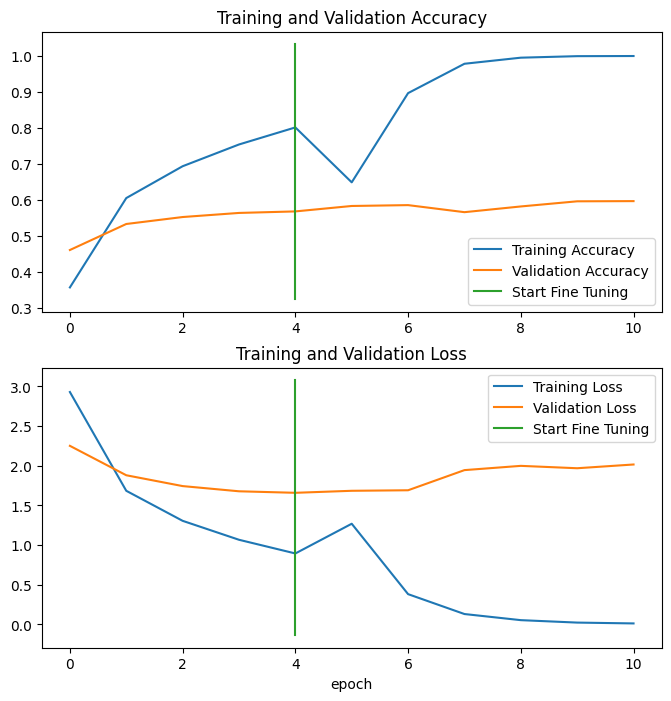

In [39]:
helper.compare_historys(history_1, history_4, EPOCHS)

In [42]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(),
    metrics=['accuracy'],
)

history_2_1 = model_2.fit(
    train_data_10_percent,
    epochs=EPOCHS,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[helper.create_checkpoint_callback("checkpoints", '06_model_2_101_classes_baseline')],
)

Saving model checkpoints to: checkpoints/06_model_2_101_classes_baseline/checkpoint.ckpt
Epoch 1/5
237/237 [==============================] - 81s 321ms/step - loss: 4.4450 - accuracy: 0.0531 - val_loss: 4.2442 - val_accuracy: 0.1083
Epoch 2/5
237/237 [==============================] - 69s 289ms/step - loss: 3.9868 - accuracy: 0.2165 - val_loss: 3.8954 - val_accuracy: 0.2270
Epoch 3/5
237/237 [==============================] - 68s 286ms/step - loss: 3.6059 - accuracy: 0.3180 - val_loss: 3.6076 - val_accuracy: 0.3051
Epoch 4/5
237/237 [==============================] - 68s 286ms/step - loss: 3.2932 - accuracy: 0.3836 - val_loss: 3.3661 - val_accuracy: 0.3475
Epoch 5/5
237/237 [==============================] - 67s 282ms/step - loss: 3.0391 - accuracy: 0.4253 - val_loss: 3.1646 - val_accuracy: 0.3814


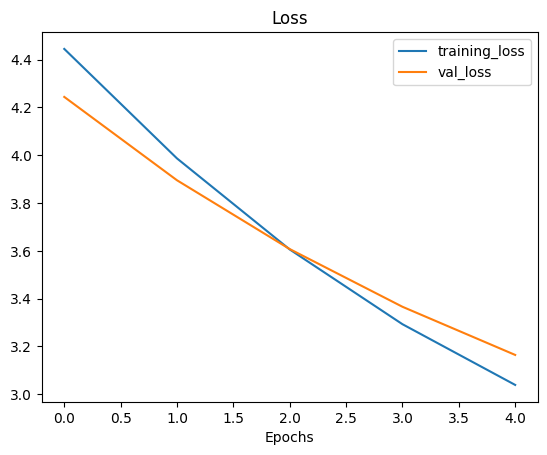

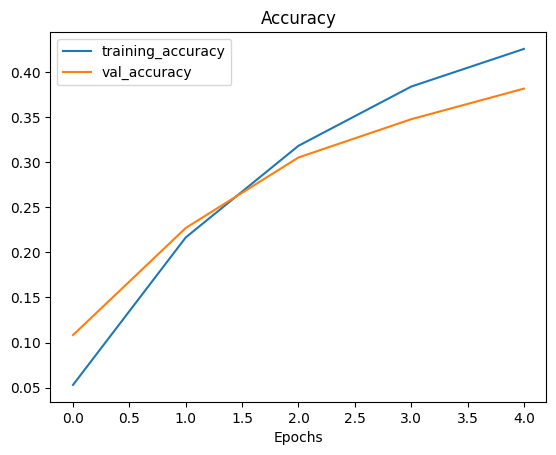

In [43]:
helper.plot_loss_curves(history_2_1)

In [44]:
evaluating_2_1 = model_2.evaluate(test_data)
evaluating_2_1

765/790 [============================>.] - ETA: 4s - loss: 2.9156 - accuracy: 0.4352

In [ ]:
evaluating_2_1

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(101*2, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(),
    metrics=['accuracy'],
)

history_3_1 = model_3.fit(
    train_data_10_percent,
    epochs=EPOCHS,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[helper.create_checkpoint_callback("checkpoints", '06_model_3_101_classes_baseline')],
)
evaluating_3_1 = model_3.evaluate(test_data)

helper.plot_loss_curves(history_3_1)
evaluating_3_1

## Making predictions with our trained model

In [39]:
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left


790/790 [==============================] - 154s 191ms/step


In [40]:
preds_probs.shape


(25250, 101)

In [41]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0]), tf.argmax(preds_probs[0]), class_names[tf.argmax(preds_probs[0])]

(array([9.65701416e-03, 2.69126293e-04, 1.06523141e-01, 3.94013114e-06,
        8.69599811e-04, 2.01564817e-05, 4.82875184e-04, 2.69613345e-04,
        3.34198400e-03, 1.28647045e-03, 1.06223277e-03, 8.07077013e-05,
        4.30297432e-03, 2.26290449e-05, 2.20462540e-03, 2.01773597e-04,
        1.30762375e-04, 6.70315349e-05, 2.09458778e-03, 4.30678570e-04,
        5.00197802e-03, 1.07956934e-04, 2.27574237e-05, 7.05167986e-05,
        7.82966497e-04, 2.97245337e-03, 7.90212129e-04, 2.01843541e-05,
        1.11917689e-01, 2.86815019e-04, 3.28157257e-05, 2.86720111e-03,
        4.62006632e-04, 3.84780324e-05, 1.21013122e-03, 1.98544250e-04,
        2.91382964e-03, 3.09685915e-04, 5.36776939e-03, 2.21706089e-03,
        1.37794341e-04, 5.71701908e-04, 2.19938680e-04, 1.15651448e-04,
        1.19144272e-03, 1.59346455e-05, 6.52472721e-03, 5.17514927e-05,
        1.62648503e-05, 1.99528575e-01, 2.28522811e-03, 7.12023257e-06,
        3.33806723e-02, 2.42919661e-03, 1.74128145e-05, 2.712078

In [44]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([85,  0,  0,  0,  0,  9, 31, 67,  2, 41])

In [45]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(np.argmax(labels))
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [63]:

# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(
    y_true: np.array,
    y_pred: np.array,
    classes: np.array = None,
    figsize=(10, 10),
    text_size=15,
    norm=False,
    savefig=False,
):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(
        cm, cmap=plt.cm.Blues
    )  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.0

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


In [64]:
make_confusion_matrix(y_labels, pred_classes, class_names, figsize=(100, 100), text_size=20, savefig=True)